In [23]:
from tqdm import tqdm_notebook as tqdm
import numpy as np

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
import pickle as pkl
data = pkl.load(open('favorited_dict.p', 'rb'))
max_item, max_user = pkl.load(open('useful_stats.p', 'rb'))
visual_data = pkl.load(open('id_feature_dict_with_artist.p', 'rb'))

In [26]:
artist_dict = pkl.load(open('artist_dict.p', 'rb'))
item_to_artist = pkl.load(open('item_to_artist.p', 'rb'))

In [27]:
removed_items = set()
for key in range(max_item):
    if key not in visual_data:
        removed_items.add(key)

In [28]:
from collections import OrderedDict

for key, value in list(artist_dict.items()):
    artist_dict[key] = list(OrderedDict.fromkeys(value))


In [29]:
for item in removed_items:
    artist = item_to_artist[item]
    artist_dict[artist].remove(item)

In [30]:
for key, value in list(artist_dict.items()):
    if not value:
        artist_dict.pop(key)

In [31]:
users_to_remove = []
for user in data:
    images = np.unique(data[user]).tolist()
    images = [image for image in images if image in visual_data]
    if not images: users_to_remove.append(user)
    else: data[user] = images

for user in users_to_remove:
    data.pop(user)

In [32]:
for key in visual_data:
    visual_data[key] = visual_data[key][0]

In [33]:
def create_validation(data):
    valid = {}
    for key in data:
        rated_items = data[key]
        if len(rated_items) > 1:
            valid[key] = np.random.choice(rated_items)
        else:
            valid[key] = None
    return valid

In [34]:
valid = create_validation(data)

In [35]:
def sample_triple(data, valid, nSamples=1):
    samples = np.zeros((nSamples, 3), dtype=int)
    keys = list(data.keys())
    users = np.random.choice(keys, nSamples) 
    samples[:, 0] = users
    
    for i, user in enumerate(tqdm(users)):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        rated_item = np.random.choice(rated_items)
        while rated_item == valid_item:
            rated_item = np.random.choice(rated_items)

        samples[i, 1] = rated_item
        samples[i, 2] = unrated_item
            
    return samples


In [36]:
vals = list(data.values())
all_items = [item for sublist in vals for item in sublist]
users_list = [[user]*len(data[user]) for user in data]
all_users = [item for sublist in users_list for item in sublist]

In [37]:
blah = list(np.unique(all_items))

In [38]:
test = np.unique([item_to_artist[x] for x in blah])

In [39]:
for artist in test:
    if artist not in artist_dict:
        print (artist_dict[artist])

In [40]:
import math

def sigmoid(x):
    try:
        if type(x) in (int, float, np.float64):
            return 1 / (1 + math.exp(-x))
        else:
            if len(x) == 1:
                x = np.squeeze(x)
                return 1 / (1 + math.exp(-x))
            else:
                return 1 / (1 + np.exp(-x))
    except OverflowError:
        return 0

In [57]:
def sample_assignment_triple(data, valid, batch_size=5):
    keys = list(data.keys())
    vals = [data[key] for key in keys]
    all_items = [item for sublist in vals for item in sublist]
    users_list = [[key]*len(data[key]) for key in keys]
    all_users = [item for sublist in users_list for item in sublist]
    samples = np.zeros((len(all_items)*batch_size, 3), dtype=int)

    samples[:,0] =  np.repeat(all_users, batch_size)
    samples[:,1] =  np.repeat(all_items, batch_size)
    
    for i, user in enumerate(all_users):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
        samples[i,2] = unrated_item

    return samples




In [144]:
assign_samples = sample_assignment_triple(data, valid, batch_size=5)


KeyboardInterrupt: 

In [119]:
#hyperparameters
k=10
n=10
lr = 0.5 
lr2 = 0.007
lam_u = .01
lam_bias = .01
lam_rated = .01
lam_unrated = .01
lam_vf = .1
lam_E = .10
lam_vu = .10
lam_smooth = 10

sf = 1

nExpertise = 5

In [145]:
'''initialize assignments'''

import math

artist_assignments = {}

for key in artist_dict:
    artworks = artist_dict[key]
    div = math.ceil(float(len(artworks))/nExpertise) 
    expertise = [int(i/div) for i, x in enumerate(artworks)]
    artist_assignments[key] = dict(zip(artworks, expertise))

In [121]:
E_old = E
vb_old = visual_bias

In [125]:
np.shape(visual_bias)

(4096, 1)

In [146]:
E = np.repeat(E_old, 5, axis=2)
visual_bias = np.repeat(vb_old, 5, axis=1)

In [127]:
artist_assignments

{0: {0: 0},
 16993: {1: 0, 26: 1, 52: 2},
 31121: {2: 0},
 36897: {3: 3,
  28: 4,
  54: 3,
  80: 4,
  105: 3,
  131: 4,
  157: 3,
  183: 0,
  209: 3,
  29617: 0,
  29643: 1,
  29669: 1,
  29695: 1,
  29721: 2,
  29747: 2,
  29773: 2,
  29799: 0,
  29825: 0,
  29851: 3,
  29877: 1,
  29903: 0,
  29928: 2,
  29954: 2,
  29979: 1,
  30005: 2,
  30031: 1,
  30057: 0},
 42712: {4: 2, 29: 2, 55: 3, 81: 1, 106: 1, 188: 0, 29697: 0},
 46169: {5: 0,
  526: 3,
  4452: 3,
  7103: 4,
  9829: 1,
  10885: 4,
  11910: 2,
  12567: 1,
  13287: 1,
  14137: 4,
  19470: 0,
  19669: 2,
  21564: 3,
  27026: 0,
  27028: 2},
 49705: {321: 0, 1411: 1},
 52910: {7: 0, 285: 1, 596: 1, 625: 2, 650: 2, 2732: 3, 7253: 0},
 2595: {8: 0},
 57875: {9: 3,
  34: 3,
  60: 3,
  86: 4,
  112: 2,
  185: 4,
  29634: 0,
  29672: 2,
  29698: 2,
  29724: 2,
  29750: 0,
  29776: 1,
  29802: 1,
  29828: 1,
  29854: 3,
  29880: 1,
  29906: 0,
  29960: 0},
 60142: {10: 0, 200: 1},
 62410: {11: 1, 235: 2, 899: 0},
 64510: {12: 0},
 

In [116]:
item_biases = np.random.normal(size=max_item)
latent_items = np.random.normal(size=(max_item, k), scale=0.1)
latent_users = np.random.normal(size=(max_user, k), scale=0.1)
visual_users = np.random.normal(size=(max_user, n), scale=0.1)
E = np.random.normal(size=(4096, n, nExpertise))
visual_bias = np.random.normal(size=(4096, nExpertise), scale=0.1)


In [46]:
import tensorflow as tf

In [94]:
#TODO: don't repeat rated calculations

def get_assignment_objective(full_samples, batch_size=200):
    objectives = {}
    #assert batch_size % 5 == 0, "Batch size must be a multiple of 5!" #TODO: should use batchsize from above fcn
        
    n_samples = len(full_samples)
    start = 0; end = start + batch_size
    pbar = tqdm(total = len(full_samples)/batch_size)

    # Define Tensorflow graph
    tf.reset_default_graph()
    vis_data = tf.placeholder(tf.float32, shape=(None, 4096))
    user = tf.placeholder(tf.float32, shape=(None, n))
    
    visual_bias_tensor = tf.convert_to_tensor(visual_bias, dtype=tf.float32)
    E_tensor = tf.convert_to_tensor(E, dtype=tf.float32)

    
    encoded = tf.einsum('kji,lk->ijl', E_tensor, vis_data)
    visual_interaction = tf.einsum('ij,kji->ik', user, encoded)

    vis_bias = tf.matmul(vis_data, visual_bias_tensor)
    obj = visual_interaction + vis_bias
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    old_item = -1 
    
    while start < n_samples:
        end = min(end, n_samples)
        samples = full_samples[start:end]

        rated_artist = [item_to_artist[x] for x in samples[:,1]]
        unrated_artist = [item_to_artist[x] for x in samples[:,2]]
        visual_user = np.array([visual_users[x] for x in samples[:,0]])
        rated_visual_data = np.array([visual_data[item] for item in samples[:,1]])
        unrated_visual_data = np.array([visual_data[item] for item in samples[:,2]])

        rated_obj = sess.run(obj, feed_dict={
                        vis_data: rated_visual_data,
                        user: visual_user,
                        })
        
        unrated_obj = sess.run(obj, feed_dict={
                        vis_data: unrated_visual_data,
                        user: visual_user,
                        })



        for i, (rated, unrated) in enumerate(zip(rated_artist, unrated_artist)):
            rated_item = samples[i,1]; unrated_item = samples[i,2]
            
            if rated not in objectives:
                objectives[rated] = {rated_item: rated_obj[i]}
            else:
                seen_art = objectives[rated]
                if rated_item not in seen_art:
                    objectives[rated][rated_item] = rated_obj[i]
                else:
                    objectives[rated][rated_item] += rated_obj[i]

            if unrated not in objectives:
                objectives[unrated] = {unrated_item: unrated_obj[i]}
            else:
                seen_art = objectives[unrated]
                if unrated_item not in seen_art:
                    objectives[unrated][unrated_item] = unrated_obj[i]
                else:
                    objectives[unrated][unrated_item] -= unrated_obj[i] #TODO: minus??
                    
        start += batch_size; end += batch_size
        pbar.update(1)
    pbar.close()
    return objectives

In [48]:
obj = {}

In [101]:
def assign_classes(samples, nExpertise):



    def DP_subproblem(nExpertise, artist_dict, chrono_art):
        buffer = np.zeros((len(artist_dict), nExpertise))
        previous_pointers = np.zeros((len(artist_dict), nExpertise))

        for i, art_number in enumerate(chrono_art):
            objs = artist_dict[art_number] 
            for expert_level in range (0, nExpertise):
                if i == 0:
                    buffer[i, expert_level] = objs[expert_level]
                    previous_pointers[i, expert_level] = -1 #base case
                else:
                    if expert_level == 0:
                        buffer[i, expert_level] = buffer[i-1, expert_level] \
                                                          + objs[expert_level]
                        previous_pointers[i, expert_level] = 0 #obviously, can't go down in skill
                    else:
                        same_level = buffer[i-1, expert_level]
                        previous_level = buffer[i-1, expert_level-1] #i.e. this one the artist "leveled up"
                        if same_level > previous_level: #Pick the one iwth the higher obj, i.e. same_level
                            buffer[i, expert_level] = same_level + objs[expert_level]
                            previous_pointers[i, expert_level] = expert_level
                        else:
                            buffer[i, expert_level] = previous_level + objs[expert_level]
                            previous_pointers[i, expert_level] = expert_level-1

   
        best_subsequence = np.zeros((len(artist_dict)), dtype=int)
        current_expert_level = np.argmax(buffer[-1,:])
        
        curr = -1
        best_subsequence[-1] = current_expert_level
        while previous_pointers[curr, expert_level] != -1: #-1 indicates "end"
            current_expert_level = previous_pointers[curr, int(current_expert_level)]
            curr -= 1
            best_subsequence[curr] = current_expert_level

        return best_subsequence #if we didn't make it into the loop
    


    #obj = get_assignment_objective(samples) #returns a dict of dicts of objectives for each artwork form each artist

    
    for artist in obj:
        artworks = list(obj[artist].keys())
        best_subsequence = DP_subproblem(nExpertise, obj[artist], artist_dict[artist])
        artist_assignments[artist] = dict(zip(artworks, best_subsequence))

    return artist_assignments

In [50]:
def BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, 
           latent_unrated_item, rated_vf, unrated_vf, rated_E, unrated_E, rated_vb, 
           unrated_vb, visual_user):
        

    bias_difference = rated_item_bias - unrated_item_bias
    
    if latent_user.ndim == 1:
        latent_difference = np.dot(latent_rated_item - latent_unrated_item, latent_user)
    else:
        latent_difference = np.einsum('ij,ji->i', latent_rated_item - latent_unrated_item, 
                                  np.transpose(latent_user)) 
        
    rated_encoded = np.dot(np.transpose(rated_E), rated_vf)
    unrated_encoded = np.dot(np.transpose(unrated_E), unrated_vf)
    visual_difference = np.dot(rated_encoded-unrated_encoded, visual_user)
    
    rated_visual_bias = np.dot(rated_vf, rated_vb)
    unrated_visual_bias = np.dot(unrated_vf, unrated_vb)
    visual_bias_difference = rated_visual_bias - unrated_visual_bias

    return (bias_difference + latent_difference + sf*visual_difference + visual_bias_difference)

In [51]:
def create_valid_dataset(data, valid, nItems=10): #nItems is the number of items not in train/ valid 
    
    valid_list = list(valid.items())
    valid_users = [x[0] for x in valid_list if x[1] is not None]
    valid_items = [x[1] for x in valid_list if x[1] is not None]
    valid_users = np.repeat(valid_users, nItems)
    valid_items = np.repeat(valid_items, nItems)
    
    samples = np.zeros((len(valid_users), 3), dtype=int)
    samples[:, 0] = valid_users
    samples[:, 1] = valid_items
    
    for i, user in enumerate(valid_users):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        samples[i, 2] = unrated_item
        
    return samples



In [52]:
def AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias):

    samples = create_valid_dataset(data, valid, 5)

    auc = 0.0
    for user, rated_item, unrated_item in tqdm(samples):

        # Extract out the relevant variables
        rated_item_bias = item_biases[rated_item]
        unrated_item_bias = item_biases[unrated_item]
        latent_user = latent_users[user]
        latent_rated_item = latent_items[rated_item]
        latent_unrated_item = latent_items[unrated_item]

        visual_user = visual_users[user]
        rated_vf = visual_data[rated_item]
        unrated_vf = visual_data[unrated_item]
        
        rated_artist = item_to_artist[rated_item]
        unrated_artist = item_to_artist[unrated_item]
        
        rated_expertise_level = artist_assignments[rated_artist][rated_item]
        unrated_expertise_level = artist_assignments[unrated_artist][unrated_item]
        
        rated_E = E[:,:,rated_expertise_level]
        unrated_E = E[:,:,unrated_expertise_level]
        
        rated_visual_bias = visual_bias[:,rated_expertise_level]
        unrated_visual_bias = visual_bias[:,unrated_expertise_level]
        
        # Determine the output, i.e. x_uij 
        br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                        rated_vf, unrated_vf,
                        rated_E, unrated_E, rated_visual_bias, unrated_visual_bias, visual_user)

        auc += (br_opt > 0)
    return auc/len(samples)

In [53]:
aucs = []

In [152]:
samples = sample_triple(data, valid, 100000)
count = 0


for user, rated_item, unrated_item in tqdm(samples):

    # ====== Extract out the relevant variables =====
    rated_item_bias = item_biases[rated_item]
    unrated_item_bias = item_biases[unrated_item]
    latent_user = latent_users[user]
    latent_rated_item = latent_items[rated_item]
    latent_unrated_item = latent_items[unrated_item]

    visual_user = visual_users[user]
    rated_vf = visual_data[rated_item]
    unrated_vf = visual_data[unrated_item]
    
    rated_artist = item_to_artist[rated_item]
    unrated_artist = item_to_artist[unrated_item]

    rated_expertise_level = artist_assignments[rated_artist][rated_item]
    unrated_expertise_level = artist_assignments[unrated_artist][unrated_item]

    rated_E = E[:, :, rated_expertise_level]
    unrated_E = E[:, :, unrated_expertise_level]

    rated_visual_bias = visual_bias[:, rated_expertise_level]
    unrated_visual_bias = visual_bias[:, unrated_expertise_level]

    # ===============================================

    # ====== Determine the output, i.e. x_uij =======
    br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                    rated_vf, unrated_vf,
                    rated_E, unrated_E, rated_visual_bias, unrated_visual_bias, visual_user)


    output = sigmoid(-br_opt)
    # ================================================



    # ====== Get Gradients ===========================
    ib_grad = output
    li_grad = output * latent_user
    lu_grad = output * (latent_rated_item-latent_unrated_item)
    
    vu_grad = sf*output * (np.dot(np.transpose(rated_E), rated_vf) - np.dot(np.transpose(unrated_E), unrated_vf))
    rated_E_grad = sf*output * (np.dot(rated_vf[:,None],visual_user[None,:]))
    unrated_E_grad = -sf*output * (np.dot(unrated_vf[:,None],visual_user[None,:]))
    rated_vb_grad = output * rated_vf
    unrated_vb_grad = -output * unrated_vf

    # ================================================


    # ====== Update parameters =======================

    item_biases[rated_item] = (1-lr*lam_bias) * rated_item_bias + lr*ib_grad
    item_biases[unrated_item] = (1-lr*lam_bias) * unrated_item_bias - lr*ib_grad

    latent_items[rated_item] = (1-lr*lam_rated) * latent_rated_item + lr*li_grad 
    latent_items[unrated_item] = (1-lr*lam_unrated) * latent_unrated_item - lr*li_grad 

    latent_users[user] = (1-lr*lam_unrated) * latent_user + lr*lu_grad
        
    if rated_expertise_level == 0:
        smaller = rated_expertise_level; larger = rated_expertise_level + 1
    elif rated_expertise_level == nExpertise-1:
        smaller = rated_expertise_level-1; larger = rated_expertise_level
    else:
        smaller = rated_expertise_level-1; larger = rated_expertise_level+1
        
    if unrated_expertise_level == 0:
        smaller_ = unrated_expertise_level; larger_ = unrated_expertise_level + 1
    elif unrated_expertise_level == nExpertise-1:
        smaller_ = unrated_expertise_level-1; larger_ = unrated_expertise_level
    else:
        smaller_ = unrated_expertise_level-1; larger_ = unrated_expertise_level+1


        
    E_smooth = lam_smooth * (E[:,:,smaller] - E[:,:,larger])
    E_smooth_ = lam_smooth * (E[:,:,smaller_] - E[:,:,larger_])
    E[:,:,rated_expertise_level] = (1-lr2*lam_E) * rated_E + lr2*rated_E_grad - lr2*E_smooth
    E[:,:,unrated_expertise_level] = (1-lr2*lam_E) * unrated_E + lr2*unrated_E_grad - lr2*E_smooth_

    visual_users[user] = (1-lr2*lam_vu) * visual_user + lr2*vu_grad
    
    vb_smooth = lam_smooth * (visual_bias[:,smaller] - visual_bias[:,larger])
    vb_smooth_ = lam_smooth * (visual_bias[:,smaller_] - visual_bias[:,larger_])
    visual_bias[:,rated_expertise_level] = \
            (1-lr2*lam_vf)*rated_visual_bias + lr2*rated_vb_grad - lr2*vb_smooth
    visual_bias[:,unrated_expertise_level] = \
            (1-lr2*lam_vf)*unrated_visual_bias + lr2*unrated_vb_grad - lr2 * vb_smooth_

    # ================================================



    count += 1
    if count % 1000000 is 0:
        aucs.append(AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias))
    #if count % 100000 is 0: lr = lr/2


In [153]:
obj = get_assignment_objective(assign_samples) #returns a dict of dicts of objectives for each artwork form each artist



In [154]:
assign_classes(assign_samples, nExpertise)

{0: {0: 3},
 16993: {1: 0, 26: 0, 52: 0},
 31121: {2: 0},
 36897: {3: 0,
  28: 0,
  54: 0,
  80: 0,
  105: 0,
  131: 0,
  157: 0,
  183: 0,
  209: 0,
  29617: 0,
  29643: 0,
  29669: 0,
  29695: 0,
  29721: 0,
  29747: 0,
  29773: 0,
  29799: 0,
  29825: 0,
  29851: 0,
  29877: 0,
  29903: 0,
  29928: 0,
  29954: 0,
  29979: 0,
  30005: 0,
  30031: 0,
  30057: 0},
 42712: {4: 0, 29: 0, 55: 0, 81: 0, 106: 0, 188: 0, 29697: 0},
 46169: {5: 0,
  526: 0,
  4452: 0,
  7103: 0,
  9829: 0,
  10885: 0,
  11910: 0,
  12567: 0,
  13287: 0,
  14137: 0,
  19470: 0,
  19669: 0,
  21564: 0,
  27026: 0,
  27028: 0},
 49705: {321: 0, 1411: 0},
 52910: {7: 0, 285: 0, 596: 0, 625: 0, 650: 0, 2732: 0, 7253: 0},
 2595: {8: 0},
 57875: {9: 0,
  34: 0,
  60: 0,
  86: 0,
  112: 0,
  185: 0,
  29634: 0,
  29672: 0,
  29698: 0,
  29724: 0,
  29750: 0,
  29776: 0,
  29802: 0,
  29828: 0,
  29854: 0,
  29880: 0,
  29906: 0,
  29960: 0},
 60142: {10: 0, 200: 0},
 62410: {11: 0, 235: 0, 899: 0},
 64510: {12: 0},
 

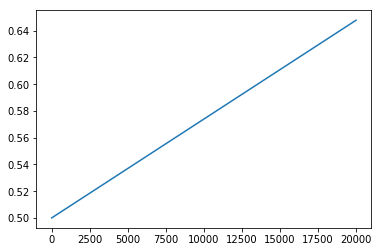

In [65]:
plt.plot(np.array(range(len(aucs)+1))*20000, [0.5]+aucs)

In [73]:
for i in range (0, 5):
    print ('\n')
    for j in range (0, 5):
        if j == i: continue
        norm = np.linalg.norm(visual_bias[:,i]-visual_bias[:,j])
        print ('Norm difference for {} and {} is {}'.format(i, j, norm))




Norm difference for 0 and 1 is 0.9300333176360472
Norm difference for 0 and 2 is 0.7745542134514031
Norm difference for 0 and 3 is 0.6889270808192406
Norm difference for 0 and 4 is 0.6012953350068261


Norm difference for 1 and 0 is 0.9300333176360472
Norm difference for 1 and 2 is 0.33818074211237475
Norm difference for 1 and 3 is 1.1058055439853756
Norm difference for 1 and 4 is 1.141417569437463


Norm difference for 2 and 0 is 0.7745542134514031
Norm difference for 2 and 1 is 0.33818074211237475
Norm difference for 2 and 3 is 0.8547538633919199
Norm difference for 2 and 4 is 0.9095873657550252


Norm difference for 3 and 0 is 0.6889270808192406
Norm difference for 3 and 1 is 1.1058055439853756
Norm difference for 3 and 2 is 0.8547538633919199
Norm difference for 3 and 4 is 0.40550750734401025


Norm difference for 4 and 0 is 0.6012953350068261
Norm difference for 4 and 1 is 1.141417569437463
Norm difference for 4 and 2 is 0.9095873657550252
Norm difference for 4 and 3 is 0.405507

In [74]:
for i in range (0, 5):
    print ('\n')
    for j in range (0, 5):
        if j == i: continue
        norm = np.linalg.norm(E[:,:,i]-E[:,:,j])
        print ('Norm difference for {} and {} is {}'.format(i, j, norm))



Norm difference for 0 and 1 is 0.4290532966163948
Norm difference for 0 and 2 is 0.34505270277202804
Norm difference for 0 and 3 is 0.7287256933833464
Norm difference for 0 and 4 is 0.6796571915145239


Norm difference for 1 and 0 is 0.4290532966163948
Norm difference for 1 and 2 is 0.3073487798143962
Norm difference for 1 and 3 is 0.957060231242144
Norm difference for 1 and 4 is 0.8369837436042055


Norm difference for 2 and 0 is 0.34505270277202804
Norm difference for 2 and 1 is 0.3073487798143962
Norm difference for 2 and 3 is 0.761522895843692
Norm difference for 2 and 4 is 0.6536500910478877


Norm difference for 3 and 0 is 0.7287256933833464
Norm difference for 3 and 1 is 0.957060231242144
Norm difference for 3 and 2 is 0.761522895843692
Norm difference for 3 and 4 is 0.4347469432719766


Norm difference for 4 and 0 is 0.6796571915145239
Norm difference for 4 and 1 is 0.8369837436042055
Norm difference for 4 and 2 is 0.6536500910478877
Norm difference for 4 and 3 is 0.434746943

(array([  1.14000000e+04,   2.41900000e+03,   9.84000000e+02,
          5.29000000e+02,   4.11000000e+02,   2.43000000e+02,
          1.93000000e+02,   1.27000000e+02,   1.00000000e+02,
          8.20000000e+01,   7.20000000e+01,   6.40000000e+01,
          5.10000000e+01,   3.30000000e+01,   3.60000000e+01,
          2.50000000e+01,   3.70000000e+01,   2.70000000e+01,
          3.10000000e+01,   2.40000000e+01,   1.90000000e+01,
          2.10000000e+01,   2.00000000e+01,   1.70000000e+01,
          1.70000000e+01,   1.20000000e+01,   1.70000000e+01,
          1.50000000e+01,   1.50000000e+01,   5.00000000e+00,
          3.00000000e+00,   8.00000000e+00,   5.00000000e+00,
          5.00000000e+00,   5.00000000e+00,   7.00000000e+00,
          1.10000000e+01,   8.00000000e+00,   6.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   6.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   3.00000000e+00,
        

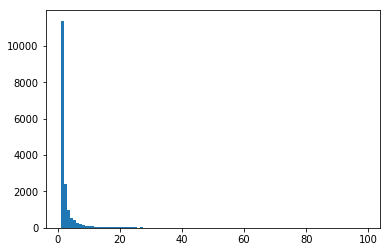

In [159]:
mylist = []
for artist in artist_assignments:
    mylist.append(len(artist_assignments[artist]))
mylist = [x for x in mylist if x < 100]

plt.hist(mylist, 100)

(array([ 61427.,      0.,   1314.,      0.,      0.,    557.,      0.,
           307.,      0.,    382.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

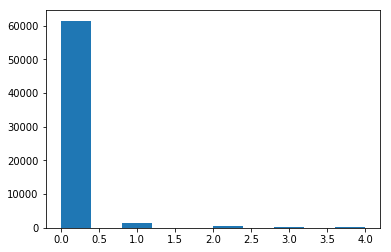

In [155]:
mylist = []
for artist in artist_assignments:
    mylist.append(list(artist_assignments[artist].values()))

mylist = [item for sublist in mylist for item in sublist]

plt.hist(mylist)

In [156]:
mylist = []
for artist in artist_assignments:
    mylist.append(list(zip(list(artist_assignments[artist].keys()), list(artist_assignments[artist].values()))))

mylist = [item for sublist in mylist for item in sublist]



img_nfavs_dict = pkl.load(open('img_nfavs.p', 'rb'))
mylist = [(y, img_nfavs_dict[x]) for (x,y) in mylist]
grouped = []
for i in range(5):
    grouped.append([x for x in mylist if x[0] == i])
    
for i in range(5):
    curr = grouped[i]
    try:
        avg = sum([x[1] for x in curr])/len(curr)
    except:
        avg = 0
    print("Average nFavs for level {} is {}".format(i, avg))

Average nFavs for level 0 is 49.577726406954596
Average nFavs for level 1 is 19.681126331811264
Average nFavs for level 2 is 12.504488330341113
Average nFavs for level 3 is 65.86319218241043
Average nFavs for level 4 is 10.43717277486911


In [ ]:
mylist[0][0]

In [ ]:
plt.figure()
plt.plot(np.array(np.abs(ib_grads[-100:-1])))
plt.plot(np.median(np.abs(np.array(lu_grads)), axis=1)[-100:-1])
plt.plot(np.median(np.abs(np.array(li_grads)), axis=1)[-100:-1])
plt.plot(np.median(np.abs(np.array(vb_grads)), axis=1)[-100:-1])
plt.plot(np.median(np.abs(np.array(vu_grads), axis=1))[-100:-1])
plt.plot(np.median(np.abs(np.array(E_grads), axis=(1,2)))[-100:-1])

In [ ]:
plt.figure()
plt.plot(np.array(np.abs(ib_grads[:100])))
plt.plot(np.median(np.abs(np.array(lu_grads)), axis=1)[:100])
plt.plot(np.median(np.abs(np.array(li_grads)), axis=1)[:100])
plt.plot(np.median(np.abs(np.array(vb_grads)), axis=1)[:100])
#plt.plot(np.median(np.array(vu_grads), axis=1))
#plt.plot(np.median(np.array(E_grads), axis=(1,2)))

In [ ]:
AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias)

item_biases = np.random.normal(size=max_item)
latent_items = np.random.normal(size=(max_item, k))
latent_users = np.random.normal(size=(max_user, k))
visual_users = np.random.normal(size=(max_user, n))
E = np.random.normal(size=(4096, n))
visual_bias = np.random.normal(size=(4096))

AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias)